In [1]:
# Define Model

import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import os

from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.optimizers import Adam
import csv
import cv2
import matplotlib.pyplot as plt
import gc
from tqdm import trange
from random import shuffle
import numpy as np
from keras.utils.np_utils import to_categorical
NUM_CHANNELS = 3
IMAGE_WIDTH = 112 # Original: 455
IMAGE_HEIGHT = 112 # Original: 256
NUM_CLASSES = 3

def preprocess(img):
    size = (IMAGE_WIDTH,IMAGE_HEIGHT)
    resized = cv2.resize(img, size)
    return resized

def load_data(fdir, lfile):
    #print("LOADING DATA FROM: %s , %s"%(fdir,lfile))
    logs = []
    features = []
    labels = []
    with open(lfile,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
    
    for i in trange(len(logs), desc="Loading Data"):
        img_path = logs[i][0]
        img = cv2.imread(fdir+img_path)
        features.append(preprocess(img))
        labels.append(float(logs[i][1]))
    return features, labels




model = Sequential([
                    Convolution2D(16, 3, 3, border_mode='same', subsample=(2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CLASSES), activation='relu'),
                    MaxPooling2D(pool_size=(3, 3)),
                    Dropout(0.2),
                    
                    Convolution2D(32, 3, 3, border_mode='same', activation='relu'),
                    MaxPooling2D(pool_size=(3, 3)),
                    Dropout(0.2),
                    
                    Convolution2D(64, 3, 3, border_mode='same', activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.2),
                    
                    Flatten(),
                    Dense(128, activation='tanh'),
                    Dropout(0.3),
                    Dense(NUM_CLASSES, activation='softmax'),
                    ])

model.load_weights('Nexar-Weights.model')

model.summary()


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", strides=(2, 2), activation="relu", input_shape=(112, 112,...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
__________

In [2]:
features_directory = './data/'
labels_file = './data/labels.csv'

features, labels = load_data(features_directory, labels_file)

features = np.array(features).astype('float32')
labels = np.array(labels).astype('float32')

train_features = features[:16792]
train_labels = labels[:16792]

test_features = features[16793:]
test_labels = labels[16793:]


Loading Data: 100%|██████████| 18658/18658 [00:14<00:00, 1300.20it/s]


In [3]:
from SafeCV_dev import *
img = test_features[1].astype('uint8')
cls = int(test_labels[1])

def red_manip(p, e):
    return [255, 0, 0]
def green_manip(p, e):
    return [0, 255, 0]

params_for_run = MCTS_Parameters(img, cls, model, predshape=(1,112,112,3))
params_for_run.verbose = True
params_for_run.simulations_cutoff = 100
params_for_run.backtracking_constant = 10
params_for_run.X_SHAPE = 112
params_for_run.Y_SHAPE = 112
params_for_run.verbose = True
params_for_run.VISIT_CONSTANT = 1
params_for_run.SIGMA_CONSTNAT = 1
params_for_run.simulations_cutoff = 100
params_for_run.target_class = 1
params_for_run.MANIP = green_manip

best_image, sev, prob, statistics = MCTS(params_for_run)

Exploring new keypoints on a new layer: 1 on node: 19
Starting DFMCS. Cuttoff: -1
Current Probability: 0.97393 Current Class: 2 Manipulations: 1  

Adversarial Example Found
Current Probability: 0.678294 Current Class: 2 Manipulations: 2 Backtracking

 Done backtracking
Back propogating and restarting search. Current Severity: 3
Best severity: 3

Exploring new keypoints on an existing layer: 1 on node: 51
Starting DFMCS. Cuttoff: 3
Current Probability: 0.892071 Current Class: 2 Manipulations: 1  

Adversarial Example Found
Current Probability: 0.992499 Current Class: 2 Manipulations: 2 Backtracking

 Done backtracking
Back propogating and restarting search. Current Severity: 3
Best severity: 3

Exploring new keypoints on an existing layer: 1 on node: 59
Starting DFMCS. Cuttoff: 3
Current Probability: 0.64675 Current Class: 2 Manipulations: 1  

Adversarial Example Found
Current Probability: 0.660668 Current Class: 2 Manipulations: 2 Backtracking

 Done backtracking
Back propogating and

BEST ADVERSARIAL EXAMPLE:


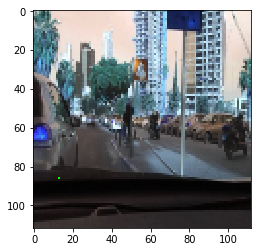

True class: 0; Predicted as: 2 with confidence: 0.833442; After 1 manipulations
MCTS Run analysis:


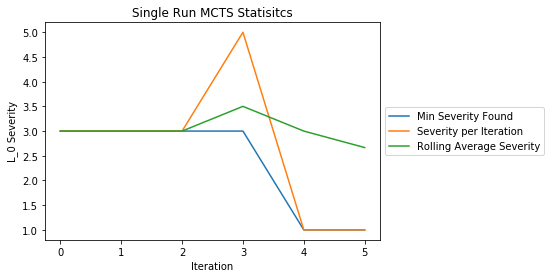

In [4]:
import matplotlib.pyplot as plt
print("BEST ADVERSARIAL EXAMPLE:")
plt.imshow(best_image)
plt.show()
prob = model.predict(best_image.reshape(1,112,112,3))
new_class = np.argmax(prob[0])
new_prob = prob[0][np.argmax(prob)]
print("True class: %s; Predicted as: %s with confidence: %s; After %s manipulations"%(cls, new_class, new_prob, sev ))
plt.clf()
print("MCTS Run analysis:")
a, = plt.plot(statistics[0], label="Min Severity Found")
b, = plt.plot(statistics[1], label="Severity per Iteration")
c, = plt.plot(statistics[2], label="Rolling Average Severity")
plt.legend(handles=[a,b,c], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Single Run MCTS Statisitcs")
plt.xlabel("Iteration")
plt.ylabel("L_0 Severity")
plt.show()